## Imports


In [1]:
import os
import numpy as np
from numpy.lib.npyio import load
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from functools import reduce

import tensorflow as tf
from tensorflow.keras.backend import flatten, sum
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, UpSampling2D, Concatenate, Flatten, GlobalAveragePooling2D
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import ResNet50


## Run config


In [2]:
saveModel = False
objectName = "drill"
modelName = "model-{}-{}".format(objectName,31)


## Configure GPU and CUDA


In [3]:
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
config


gpu_options {
  per_process_gpu_memory_fraction: 0.8
  allow_growth: true
}

## Helper methods


In [4]:
def loadData(path:str, labels:list, imgSize:tuple, colorMode:str='grayscale', validationSubset:bool=False) -> tf.data.Dataset:
    batch_size = 32
    subset = "validation" if validationSubset else "training"

    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels=labels,
        color_mode=colorMode,
        image_size=imgSize,
        batch_size=batch_size,
        validation_split=0.2,
        subset=subset,
        seed=123
    )

def loadTestData(path:str, labels:list, imgSize:tuple, colorMode:str='grayscale') -> tf.data.Dataset:
    batch_size = 32
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels=labels,
        color_mode=colorMode,
        image_size=imgSize,
        batch_size=batch_size,
    )

def loadImagesFromDir(basePath, imgSize:tuple, colorMode:str='grayscale'):
    imagePaths = [basePath + imageName for imageName in os.listdir(basePath)]
    return [tf.keras.preprocessing.image.img_to_array(img) 
            for img in [tf.keras.preprocessing.image.load_img(
                    imagePath,
                    color_mode=colorMode, 
                    target_size=imgSize) for imagePath in imagePaths]]

def plotObjectsWithKeypoints(slice:int, images:list, labels:list, yPred:np.ndarray) -> None:
    plt.figure(figsize=(15,15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(images[9*slice+i]), cmap='gray')
        plt.scatter(yPred[9*slice+i][0::2]*imageH, yPred[9*slice+i][1::2]*imageH, marker='x', s=50, c='red')
        plt.scatter(labels[9*slice+i][0::2]*imageH, labels[9*slice+i][1::2]*imageH, marker='x', s=50, c='green')
        plt.axis("off")
    plt.show()

def plotTrainingHistory(histories:List[tf.keras.callbacks.History], metric:str, epochs_range) -> None:
    loss = reduce(lambda a,b: a+b, [h.history[metric] for h in histories])
    val_loss = reduce(lambda a,b: a+b, [h.history['val_{}'.format(metric)] for h in histories])

    plt.figure(figsize=(8, 8))
    plt.plot(epochs_range, loss, label='Training {}'.format(metric))
    plt.plot(epochs_range, val_loss, label='Validation {}'.format(metric))
    plt.legend(loc='upper right')
    plt.title('Training and Validation {}'.format(metric))
    plt.show()


## Load datasets


In [5]:
testDataSize = np.load('resources/{}/{}_keypoints_test.npy'.format(objectName, objectName)).shape[0]
trainDataSize = np.load('resources/{}/{}_keypoints_train.npy'.format(objectName, objectName)).shape[0]
imageH = 128
imageW = 128
numFeatures = 16

dsTrain = loadData(path='resources/{}/train'.format(objectName),
            labels=list(np.load('resources/{}/{}_keypoints_train.npy'.format(objectName, objectName)).reshape(trainDataSize, numFeatures)),
            imgSize=(imageH,imageW),
            colorMode='rgb',
            validationSubset=False)

dsValid = loadData(path='resources/{}/train'.format(objectName),
                    labels=list(np.load('resources/{}/{}_keypoints_train.npy'.format(objectName, objectName)).reshape(trainDataSize,numFeatures)),
                    imgSize=(imageH,imageW),
                    colorMode='rgb',
                    validationSubset=True)

dsTest = loadTestData(path='resources/{}/test'.format(objectName),
                    labels=list(np.load('resources/{}/{}_keypoints_test.npy'.format(objectName, objectName)).reshape(testDataSize, numFeatures)),
                    colorMode='rgb',
                    imgSize=(imageH,imageW))



Found 294 files belonging to 1 classes.
Using 236 files for training.
Found 294 files belonging to 1 classes.
Using 58 files for validation.
Found 66 files belonging to 1 classes.


## Configure performance


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dsTrain = dsTrain.cache().shuffle(300) \
    .prefetch(buffer_size=AUTOTUNE)

dsValid = dsValid.cache() \
    .prefetch(buffer_size=AUTOTUNE)



## Create basic model


In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(imageH, imageW, 3))
 
for layer in base_model.layers:
    layer.trainable = True
 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(16)(x) 
 
model = Model(inputs=[base_model.input], outputs=[predictions])
 
model.compile(optimizer=Adam(learning_rate=0.0005),
            loss="mean_squared_error",
            metrics=['mae'])
 
model.summary()


onv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 8, 8, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 8, 8, 256)    590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 8, 8, 256)    1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 8, 8, 256)    0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 8, 8, 1024)   525312      conv3_block4_out[0][0]    

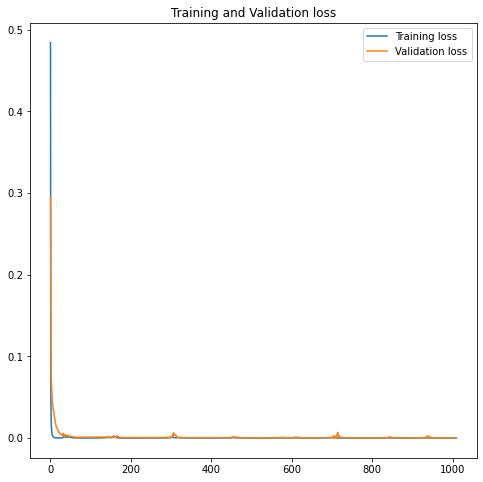

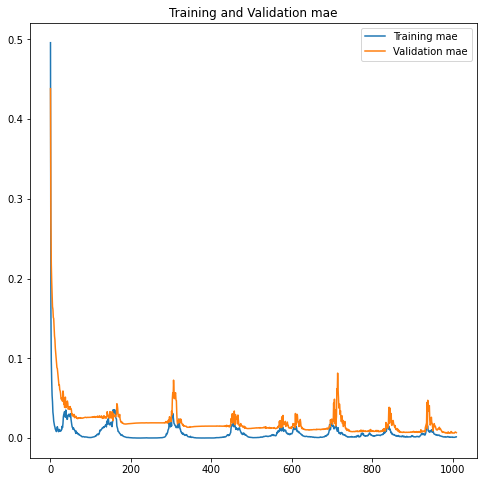

EVALUATE
3/3 - 0s - loss: 7.6463e-05 - mae: 0.0068


In [15]:
plotTrainingHistory(histories, metric='loss', epochs_range=range(totalEpochs))
plotTrainingHistory(histories, metric='mae', epochs_range=range(totalEpochs))

print("EVALUATE")
test_loss, test_acc = model.evaluate(dsTest, verbose=2)


# Plot prediction results


BEST



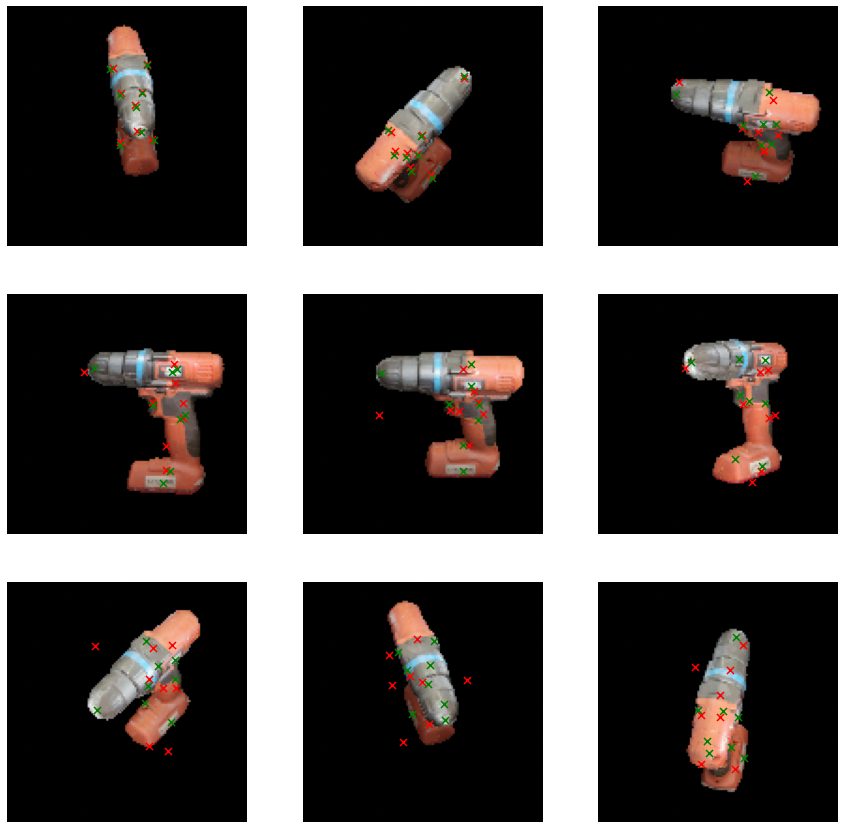


WORST



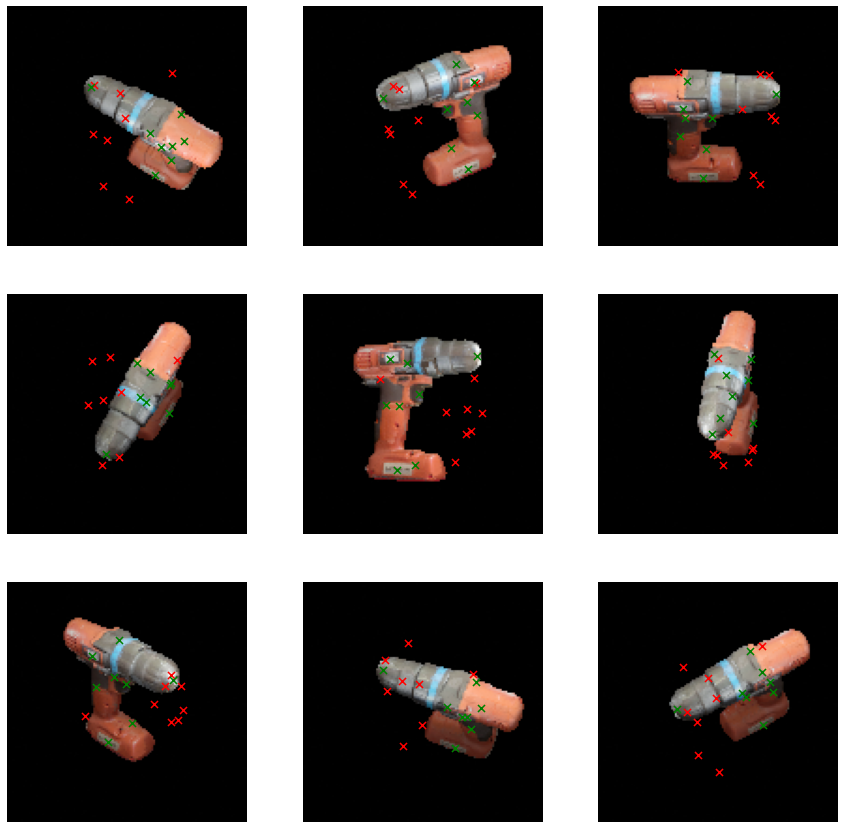

In [16]:
a = list(zip(images, labels, yPred))
a.sort(key=lambda t: mean_absolute_error(t[1], t[2]).numpy())
a = np.array(a)

print("BEST\n")
plotObjectsWithKeypoints(slice=0, images=a[:,0], labels=a[:,1], yPred=a[:,2])

print("\nWORST\n")
plotObjectsWithKeypoints(slice=6, images=a[:,0], labels=a[:,1], yPred=a[:,2])

